In [ ]:
from google.colab import files
uploaded = files.upload()

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import os
import pickle

import string

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_curve

In [2]:
dt=pd.read_csv("Sarcasm_dataset.csv")
dt.head()

article_link  \
0  https://www.huffingtonpost.com/entry/versace-b...   
1  https://www.huffingtonpost.com/entry/roseanne-...   
2  https://local.theonion.com/mom-starting-to-fea...   
3  https://politics.theonion.com/boehner-just-wan...   
4  https://www.huffingtonpost.com/entry/jk-rowlin...   

                                            headline  is_sarcastic  
0  former versace store clerk sues over secret 'b...             0  
1  the 'roseanne' revival catches up to our thorn...             0  
2  mom starting to fear son's web series closest ...             1  
3  boehner just wants wife to listen, not come up...             1  
4  j.k. rowling wishes snape happy birthday in th...             0

In [3]:
dt.drop('article_link', axis = 1, inplace = True)
dt.head()

headline  is_sarcastic
0  former versace store clerk sues over secret 'b...             0
1  the 'roseanne' revival catches up to our thorn...             0
2  mom starting to fear son's web series closest ...             1
3  boehner just wants wife to listen, not come up...             1
4  j.k. rowling wishes snape happy birthday in th...             0

In [4]:
y=dt['is_sarcastic']

<Axes: ylabel='is_sarcastic'>

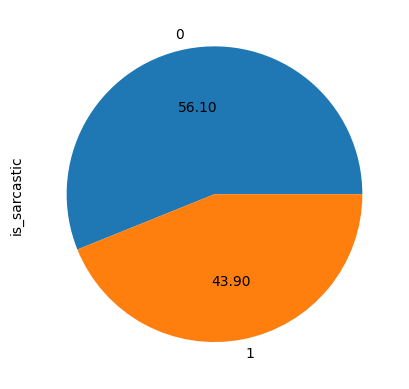

In [5]:
y.value_counts().plot.pie(autopct='%.2f')

In [6]:
dt['length'] = dt['headline'].apply(lambda x: len(x))
dt.head()

headline  is_sarcastic  length
0  former versace store clerk sues over secret 'b...             0      78
1  the 'roseanne' revival catches up to our thorn...             0      84
2  mom starting to fear son's web series closest ...             1      79
3  boehner just wants wife to listen, not come up...             1      84
4  j.k. rowling wishes snape happy birthday in th...             0      64

In [7]:
import re

def text_cleaner(text):
    #converting to lowercase
    text1 = text.lower()
    #removing links
    text1 = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text1)
    #fetching alphabetic characters
    text1 = re.sub('[^a-zA-Z#@]', ' ',text1)
    return text1

In [8]:
dt = dt.sample(frac=1, random_state=42)

In [9]:
dt['cleaned_tweet'] = dt['headline'].apply(text_cleaner)

dt.head()

headline  is_sarcastic  \
6913   isis recruiter excited to be talking to popula...             1   
11611  jimmy fallon could barely keep it together dur...             0   
25947  drunk ron weasley wishing harry potter 'happy ...             0   
24478            hoosier hostility: not the american way             0   
11863  turns out running doesn't wreck your knees aft...             0   

       length                                      cleaned_tweet  
6913       70  isis recruiter excited to be talking to popula...  
11611      72  jimmy fallon could barely keep it together dur...  
25947      69  drunk ron weasley wishing harry potter  happy ...  
24478      39            hoosier hostility  not the american way  
11863      52  turns out running doesn t wreck your knees aft...

In [10]:
len(dt),dt.index.shape[-1]

(26709, 26709)

In [11]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [13]:
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_stopwords(text):
    removed = []
    stop_words = list(stopwords.words("english"))
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        if tokens[i] not in stop_words:
            removed.append(tokens[i])
    return " ".join(removed)
def remove_extra_white_spaces(text):
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
    return without_sc
def lemmatizing(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        lemma_word = lemmatizer.lemmatize(tokens[i])
        tokens[i] = lemma_word
    return " ".join(tokens)


lemmatizing('life sentence reduced to 2 years')

'life sentence reduced to 2 year'

In [14]:

dt['cleaned_tweet'] = dt['cleaned_tweet'].apply(lambda x: remove_punctuation(x))
dt['cleaned_tweet'] = dt['cleaned_tweet'].apply(lambda x: remove_stopwords(x))
dt['cleaned_tweet'] = dt['cleaned_tweet'].apply(lambda x: remove_extra_white_spaces(x))
dt['cleaned_tweet'] = dt['cleaned_tweet'].apply(lambda x: lemmatizing(x))
dt['length_after_cleaning'] = dt['cleaned_tweet'].apply(lambda x: len(x))

In [15]:
dt.head()

headline  is_sarcastic  \
6913   isis recruiter excited to be talking to popula...             1   
11611  jimmy fallon could barely keep it together dur...             0   
25947  drunk ron weasley wishing harry potter 'happy ...             0   
24478            hoosier hostility: not the american way             0   
11863  turns out running doesn't wreck your knees aft...             0   

       length                                      cleaned_tweet  \
6913       70  isi recruiter excited talking popular high sch...   
11611      72  jimmy fallon could barely keep together cardi ...   
25947      69  drunk ron weasley wishing harry potter happy b...   
24478      39                     hoosier hostility american way   
11863      52                            turn running wreck knee   

       length_after_cleaning  
6913                      51  
11611                     55  
25947                     64  
24478                     30  
11863                     23

In [16]:
from sklearn.model_selection import train_test_split

X_traintf, X_testtf, y_traintf, y_testtf = train_test_split(
    dt.cleaned_tweet,
    dt.is_sarcastic,
    test_size=0.2, # 20% samples will go to test dataset
    random_state=2022,
    stratify=dt.is_sarcastic
)

In [17]:
from sklearn.naive_bayes import MultinomialNB


#1. create a pipeline object
clf = Pipeline([
     ('vectorizer_tfidf',TfidfVectorizer()),
     ('Multi NB', MultinomialNB())
])

#2. fit with X_train and y_train
clf.fit(X_traintf, y_traintf)


#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_testtf)


#4. print the classfication report
print(classification_report(y_testtf, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.90      0.83      2997
           1       0.84      0.64      0.72      2345

    accuracy                           0.79      5342
   macro avg       0.80      0.77      0.78      5342
weighted avg       0.79      0.79      0.78      5342



In [18]:
from imblearn.over_sampling import RandomOverSampler

In [19]:
X_train, X_test, y_train, y_test = train_test_split(dt['cleaned_tweet'], dt['is_sarcastic'].values, test_size=0.20)
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)
X_traintf = vectorizer.transform(X_train)
X_traintf = X_traintf.toarray()
#Vectorizing the X_test
X_testtf = vectorizer.transform(X_test)
X_testtf = X_testtf.toarray()


In [20]:
ROS = RandomOverSampler(sampling_strategy=1)
X_ros, y_ros = ROS.fit_resample(X_traintf, y_train)
Counter(y_ros)

Counter({1: 11949, 0: 11949})

In [21]:
nb=MultinomialNB()
nb.fit(X_ros, y_ros)
y_preds = nb.predict(X_testtf)
print(y_preds)
X_testtf

[1 0 0 ... 0 0 0]


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [22]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.82      0.79      0.80      3036
           1       0.74      0.77      0.75      2306

    accuracy                           0.78      5342
   macro avg       0.78      0.78      0.78      5342
weighted avg       0.78      0.78      0.78      5342



Confusion Matrix: [[2407  629]
 [ 540 1766]]


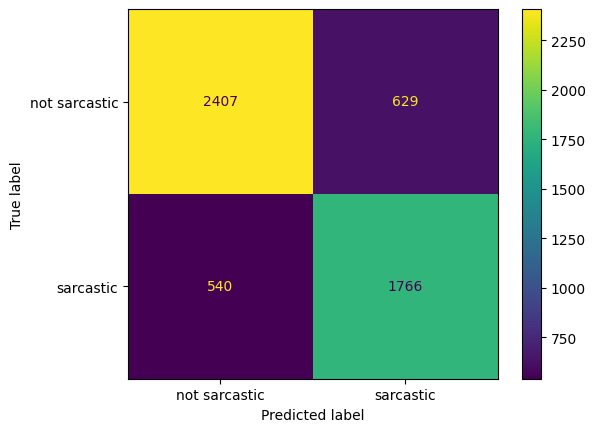

In [23]:
cm = confusion_matrix(y_test, y_preds)
print("Confusion Matrix:", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["not sarcastic", "sarcastic"])
disp.plot()
plt.show()

In [24]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(dt['cleaned_tweet'])
y = dt['is_sarcastic']
# Splitting the dataset into training dataset and testing dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
clf = LogisticRegression()

In [26]:
clf.fit(X_ros, y_ros)

LogisticRegression()

In [27]:
y_pred = clf.predict(X_testtf)

y_pred

array([1, 0, 0, ..., 0, 0, 1])

In [28]:
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

Accuracy: 0.5144140771246724


Confusion Matrix: [[1704 1264]
 [1330 1044]]


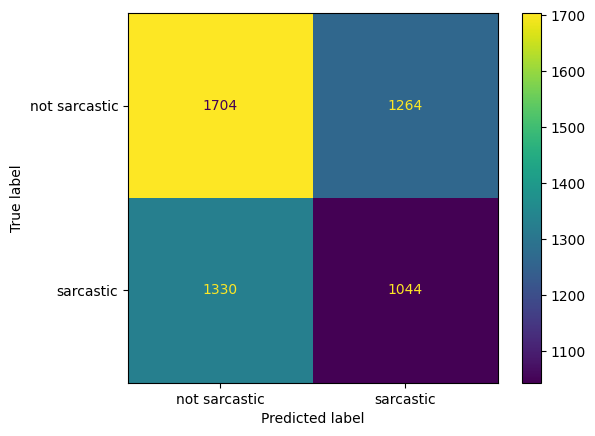

In [29]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["not sarcastic", "sarcastic"])
disp.plot()
plt.show()

In [30]:
clf.fit(X_ros, y_ros)
y_preds = clf.predict(X_testtf)
print(y_preds)

[1 0 0 ... 0 0 1]


In [31]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.56      0.57      0.57      2968
           1       0.45      0.44      0.45      2374

    accuracy                           0.51      5342
   macro avg       0.51      0.51      0.51      5342
weighted avg       0.51      0.51      0.51      5342



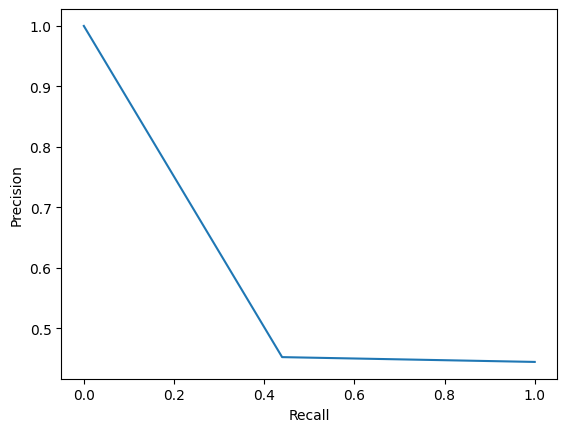

In [32]:
precision, recall, thresholds = precision_recall_curve(y_test, y_preds)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()